In [1]:
!pip3 install minisom

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from minisom import MiniSom

In [3]:
m, n = 22, 22
sigma, lr = 1.6, 0.35
iters = 6000
outlier_pct = 95
tsne_perplexity, tsne_iter = 35, 1200
rng = 0
summary = []

In [4]:
scaler = StandardScaler()

# Dataset dos Vinhos

O Wine Dataset traz dados químicos de diferentes tipos de vinho, usados para comparar e identificar padrões entre eles.

In [6]:
wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
wine_cols = ['Class','Alcohol','Malic_acid','Ash','Alcalinity_of_ash','Magnesium','Total_phenols','Flavanoids','Nonflavanoid_phenols','Proanthocyanins','Color_intensity','Hue','OD280/OD315','Proline']
wine_df = pd.read_csv(wine_url, names=wine_cols)
wine_df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [8]:
wine_df.shape

(178, 14)

In [7]:
wine_df.isnull().sum()

,0
Class,0
Alcohol,0
Malic_acid,0
Ash,0
Alcalinity_of_ash,0
Magnesium,0
Total_phenols,0
Flavanoids,0
Nonflavanoid_phenols,0
Proanthocyanins,0


In [9]:
wine_df.duplicated().sum()

np.int64(0)

In [10]:
X_wine = scaler.fit_transform(wine_df.drop(columns=['Class']).to_numpy(dtype=float))

In [11]:
som_w = MiniSom(x=m, y=n, input_len=X_wine.shape[1], sigma=sigma, learning_rate=lr, neighborhood_function='gaussian', random_seed=rng)
som_w.random_weights_init(X_wine)
som_w.train_random(X_wine, iters)

In [12]:
bmus_w = np.array([som_w.winner(x) for x in X_wine])

In [13]:
labels_w = bmus_w[:,0]*n + bmus_w[:,1]

In [15]:
W_w = som_w.get_weights().reshape(-1, X_wine.shape[1])

In [16]:
winners_w = labels_w

In [17]:
dists_w = np.linalg.norm(X_wine - W_w[winners_w], axis=1)

In [18]:
QE_w = dists_w.mean()
print(f'Quantization Error: {QE_w:.2f}')

Quantization Error: 0.36


In [19]:
bad_w = 0

In [20]:
for x in X_wine:
    d = np.linalg.norm(W_w - x, axis=1); a, b = np.argsort(d)[:2]; ra, ca = divmod(a, n); rb, cb = divmod(b, n)
    if (abs(ra - rb) + abs(ca - cb)) != 1: bad_w += 1

In [21]:
TE_w = bad_w / len(X_wine)
print(f'Topological Error: {TE_w:.2f}')
thr_w = np.percentile(dists_w, outlier_pct)
out_w = dists_w >= thr_w

Topological Error: 0.07


In [22]:
Xw_pca = PCA(n_components=2, random_state=rng).fit_transform(X_wine)

In [23]:
K_w = max(2, min(10, len(X_wine)//30))
km_w = KMeans(n_clusters=K_w, n_init=10, random_state=rng).fit(W_w)

In [24]:
lab_w_m = km_w.labels_[winners_w]
silw_p = silhouette_score(Xw_pca, lab_w_m)
dbw_p  = davies_bouldin_score(Xw_pca, lab_w_m)
chw_p  = calinski_harabasz_score(Xw_pca, lab_w_m)

In [28]:
print('silhouette_score: ',silw_p)
print('davies_bouldin_score: ' , dbw_p)
print('calinski_harabasz_score: ', chw_p)

silhouette_score:  0.2801750595208776
davies_bouldin_score:  1.7640568457638524
calinski_harabasz_score:  172.89144870106182


In [25]:
Xw_tsne = TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=tsne_iter, learning_rate='auto', init='pca', random_state=rng).fit_transform(X_wine)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [26]:
Xw_tsne.shape

(178, 2)

In [27]:
silw_t = silhouette_score(Xw_tsne, lab_w_m)
dbw_t  = davies_bouldin_score(Xw_tsne, lab_w_m)
chw_t  = calinski_harabasz_score(Xw_tsne, lab_w_m)

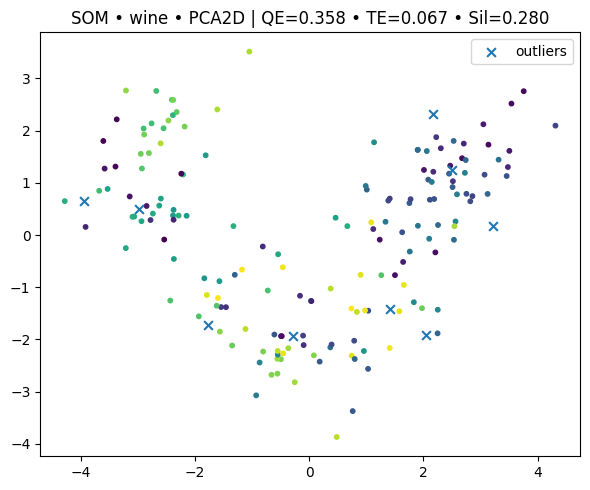

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(Xw_pca[~out_w,0], Xw_pca[~out_w,1], c=labels_w[~out_w], s=10)
plt.scatter(Xw_pca[out_w,0], Xw_pca[out_w,1], marker='x', s=40, label='outliers')
plt.title(f"SOM • wine • PCA2D | QE={QE_w:.3f} • TE={TE_w:.3f} • Sil={silw_p:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

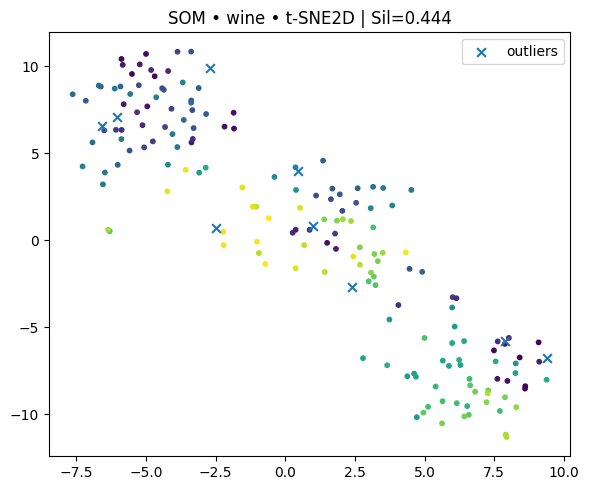

In [30]:
plt.figure(figsize=(6,5))
plt.scatter(Xw_tsne[~out_w,0], Xw_tsne[~out_w,1], c=labels_w[~out_w], s=10)
plt.scatter(Xw_tsne[out_w,0], Xw_tsne[out_w,1], marker='x', s=40, label='outliers')
plt.title(f"SOM • wine • t-SNE2D | Sil={silw_t:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
summary.append({"dataset":"wine","m":m,"n":n,"sigma":sigma,"lr":lr,"iters":iters,"QE":QE_w,"TE":TE_w,"sil_PCA":silw_p,"DB_PCA":dbw_p,"CH_PCA":chw_p,"sil_tSNE":silw_t,"DB_tSNE":dbw_t,"CH_tSNE":chw_t,"outlier_thr":thr_w})

# ionosphere

O Ionosphere Dataset contém medições de sinais de radar, usadas para distinguir se o sinal captado é bom ou ruim.

In [32]:
ion_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
ion_cols = [f'feat_{i}' for i in range(34)] + ['Label']
ion_df = pd.read_csv(ion_url, names=ion_cols)
ion_df.shape

(351, 35)

In [33]:
ion_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,Label
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [34]:
ion_df.duplicated().sum()

np.int64(1)

In [35]:
ion_df.drop_duplicates(inplace=True)
ion_df.shape

(350, 35)

In [36]:
ion_df.isnull().sum()

,0
feat_0,0
feat_1,0
feat_2,0
feat_3,0
feat_4,0
feat_5,0
feat_6,0
feat_7,0
feat_8,0
feat_9,0


In [37]:
X_iono = scaler.fit_transform(ion_df.drop(columns=['Label']).astype(float).to_numpy())

In [38]:
som_i = MiniSom(x=m, y=n, input_len=X_iono.shape[1], sigma=sigma, learning_rate=lr, neighborhood_function='gaussian', random_seed=rng)
som_i.random_weights_init(X_iono)
som_i.train_random(X_iono, iters)

In [39]:
bmus_i = np.array([som_i.winner(x) for x in X_iono])
labels_i = bmus_i[:,0]*n + bmus_i[:,1]

In [40]:
W_i = som_i.get_weights().reshape(-1, X_iono.shape[1])
winners_i = labels_i
dists_i = np.linalg.norm(X_iono - W_i[winners_i], axis=1)

In [41]:
bad_i = 0
QE_i = dists_i.mean()
print(QE_i)

1.108344883780805


In [42]:
for x in X_iono:
    d = np.linalg.norm(W_i - x, axis=1); a, b = np.argsort(d)[:2]; ra, ca = divmod(a, n); rb, cb = divmod(b, n)
    if (abs(ra - rb) + abs(ca - cb)) != 1: bad_i += 1

In [43]:
TE_i = bad_i / len(X_iono)
thr_i = np.percentile(dists_i, outlier_pct)
out_i = dists_i >= thr_i

In [44]:
Xi_pca = PCA(n_components=2, random_state=rng).fit_transform(X_iono)

In [45]:
K_i = max(2, min(10, len(X_iono)//30))

In [46]:
km_i = KMeans(n_clusters=K_i, n_init=10, random_state=rng).fit(W_i)

In [47]:
lab_i_m = km_i.labels_[winners_i]

In [48]:
sili_p = silhouette_score(Xi_pca, lab_i_m)
dbi_p  = davies_bouldin_score(Xi_pca, lab_i_m)
chi_p  = calinski_harabasz_score(Xi_pca, lab_i_m)
print('silhouette_score: ',sili_p)
print('davies_bouldin_score: ' , dbi_p)
print('calinski_harabasz_score: ', chi_p)

silhouette_score:  0.14673450549067915
davies_bouldin_score:  3.2173310610938906
calinski_harabasz_score:  112.05777165017798


In [49]:
Xi_tsne = TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=tsne_iter, learning_rate='auto', init='pca', random_state=rng).fit_transform(X_iono)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [50]:
sili_t = silhouette_score(Xi_tsne, lab_i_m)
dbi_t  = davies_bouldin_score(Xi_tsne, lab_i_m)
chi_t  = calinski_harabasz_score(Xi_tsne, lab_i_m)
print(sili_t)
print(dbi_t)
print(chi_t)

0.15685374
1.5278464673565577
118.56565


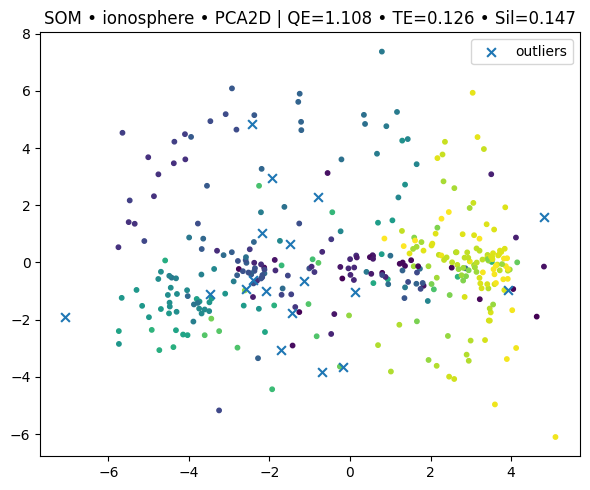

In [51]:
plt.figure(figsize=(6,5))
plt.scatter(Xi_pca[~out_i,0], Xi_pca[~out_i,1], c=labels_i[~out_i], s=10)
plt.scatter(Xi_pca[out_i,0], Xi_pca[out_i,1], marker='x', s=40, label='outliers')
plt.title(f"SOM • ionosphere • PCA2D | QE={QE_i:.3f} • TE={TE_i:.3f} • Sil={sili_p:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

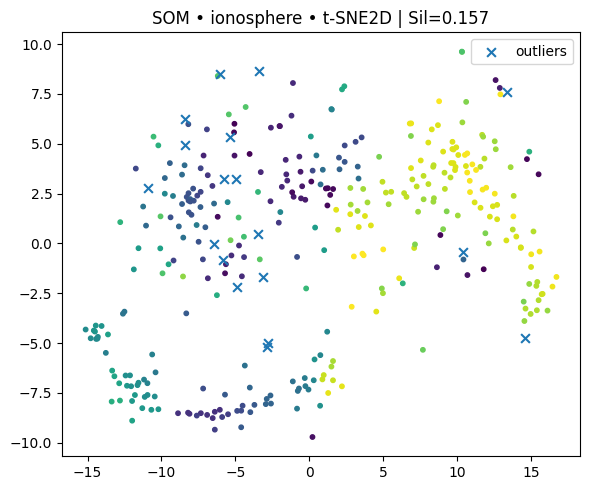

In [52]:
plt.figure(figsize=(6,5))
plt.scatter(Xi_tsne[~out_i,0], Xi_tsne[~out_i,1], c=labels_i[~out_i], s=10)
plt.scatter(Xi_tsne[out_i,0], Xi_tsne[out_i,1], marker='x', s=40, label='outliers')
plt.title(f"SOM • ionosphere • t-SNE2D | Sil={sili_t:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
summary.append({"dataset":"ionosphere","m":m,"n":n,"sigma":sigma,"lr":lr,"iters":iters,"QE":QE_i,"TE":TE_i,"sil_PCA":sili_p,"DB_PCA":dbi_p,"CH_PCA":chi_p,"sil_tSNE":sili_t,"DB_tSNE":dbi_t,"CH_tSNE":chi_t,"outlier_thr":thr_i})

# Final

In [54]:
print(pd.DataFrame(summary).round(4))

      dataset   m   n  sigma    lr  iters      QE      TE  sil_PCA  DB_PCA  \
0        wine  22  22    1.6  0.35   6000  0.3582  0.0674   0.2802  1.7641   
1  ionosphere  22  22    1.6  0.35   6000  1.1083  0.1257   0.1467  3.2173   

     CH_PCA  sil_tSNE  DB_tSNE     CH_tSNE  outlier_thr  
0  172.8914    0.4437   1.1566  364.699585       0.6937  
1  112.0578    0.1569   1.5278  118.565598       2.6719  


Os resultados mostram que o SOM funcionou bem no conjunto de dados do Wine, mas teve mais dificuldade no Ionosphere. No Wine, o erro foi baixo e o mapa conseguiu organizar bem os dados, formando grupos ate que claros e com poucos outliers. As métricas também foram boas, especialmente no t-SNE, que mostrou separação visível entre os grupos.

Já no Ionosphere, o erro foi maior e os grupos ficaram misturados. As métricas mostraram pouca separação entre os dados, o que é normal porque esse conjunto tem muitas variáveis e bastante ruído.

# Referencias

- Kohonen, T. (2001) Self-Organizing Maps (3rd ed.). Springer.

- Vettigli, G. (2018) MiniSom — Minimalistic SOM implementation (PyPI/GitHub).
- Rousseeuw, P. J. (1987). Silhouettes. J. Comput. Appl. Math.
- van der Maaten & Hinton (2008) Visualizing Data using t-SNE, JMLR.
- UCI Machine Learning Repository: Wine e Ionosphere.
- Quiles, M. (2024). SELF-ORGANISING MAPS (SOM). Aula da disciplina de Redes Neurais.